# Tarea 2
## Importación de módulos

In [1325]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from IPython.display import display
import matplotlib.pyplot as plt

## Clase del problema

In [1326]:
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3,#Cantidad de genes por cromosoma
                        n_obj=2,#cantidad de funciones objetivo
                        xl=0,#Limite inferior del valor del gen
                        xu=200)#Limite superior del valor de gen
        
    def _evaluate(self, x, out, *args, **kwargs):
        
        # Cantidad de tornos
        T = x[0]
        # Cantidad de fresadoras
        F = x[1]
        # Cantidad de multiproposito
        M = x[2]
        
        #Se definen las penalizaciones por el sobrepaso de material 
        penCab = 280 - (2*T+F+5*M)#Cableado
        penM  = 120 - (6*T+3*F+12*M)#Motores
        penCar = 670 - (2*T+8*F+4*M)#Carcasas
        penA = 250 - (2*T+6*F+6*M)#Actuadores
        
        penalizaciones = [penCab, penM, penCar, penA] #Vector con las penalizaciones
        
        pen = 0
        #Sumatoria de penalizaciones
        for i in range(4):
            if penalizaciones[i] < 0:
                pen = pen + penalizaciones[i]
        
        #Funciones objetivo
        f1 = -(4*T+8*F+12*M)+pen**2 #Funcion que busca la mayor ganancia
        f2 = (abs(T-F)+abs(T-M)+abs(F-M))**3 #Funcion que busca la cantidad de unidades sea uniforme
        out["F"] = [f1, f2]
        
problem = MyProblem()    

## Inicialización del algoritmo

In [1327]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.crossover.pntx import SinglePointCrossover

# Se utiliza el algoritmo NSGA2 
#Automaticamente se utiliza un el algoritmo de torneo para la selección del cruzamiento
algorithm = NSGA2(pop_size=200,#Numero de la poblacion inicial 
                sampling=IntegerRandomSampling(),
                crossover=SinglePointCrossover(),
                mutation=PM(prob=0.05, vtype=float, repair=RoundingRepair()),#Mutacion
                eliminate_duplicates = True)

## Criterio de parada

In [1328]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 100)#Cantidad de generaciones

## Optimización y Normalización

In [1329]:
from pymoo.optimize import minimize
#Se utiliza una funcion de minimización para minimizar las funciones objetivo
res = minimize(problem,
            algorithm,
            termination,
            save_history=True,
            verbose=True)

X = res.X #Vector de soluciones
res.F = res.F*-1
F = res.F #Vector con las calidades de cada individuo
hist = res.history

#Normalización del resultado

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)#Normalización del frente de Pareto

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      3 |             - |             -
     2 |      400 |      5 |  0.0139442439 |         ideal
     3 |      600 |      3 |  0.0534490635 |         ideal
     4 |      800 |      6 |  0.1452305000 |             f
     5 |     1000 |      6 |  0.6545729403 |         nadir
     6 |     1200 |      5 |  0.0052631579 |         ideal
     7 |     1400 |      6 |  0.0253146013 |             f
     8 |     1600 |      7 |  5.523701E+01 |         nadir
     9 |     1800 |      8 |  0.0079320113 |         ideal
    10 |     2000 |     10 |  0.0033242756 |             f
    11 |     2200 |      9 |  3.360784E+01 |         nadir
    12 |     2400 |     10 |  0.0882352941 |         ideal
    13 |     2600 |     13 |  0.3333333333 |         nadir
    14 |     2800 |     15 |  0.0084357998 |             f
    15 |     3000 |     14 |  0.0377358491 |         ideal
    16 |     3200 |     15 |  0.0025252084 |            

## Convergencia de Cada Objetivo

In [1330]:
from pymoo.indicators.hv import HV

A = nF[::7] # se toma una muestra del frente cada 7 soluciones
ref_point = np.array([1.2, 1.2]) # se pone el punto de referencia (un punto muy malo) como -120 para f1 y 6000 para f2 
ind = HV(ref_point=ref_point) # se calcula el indicador del hypervolumen

print("HV", '%.5f' % ind(A)) # se imprime el indicador con cinco decimales


HV 0.41323


## Visualización de Resultados y Mejor resultado por medio de Compromise Programing 

Best regarding ASF: Point 
i = 23
F = [    248. -125000.]
X = [ 2 27  2]


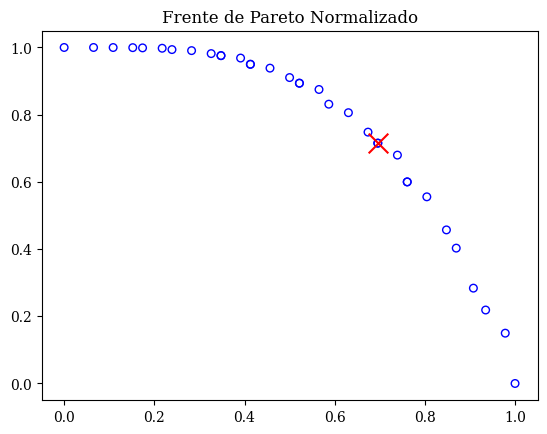

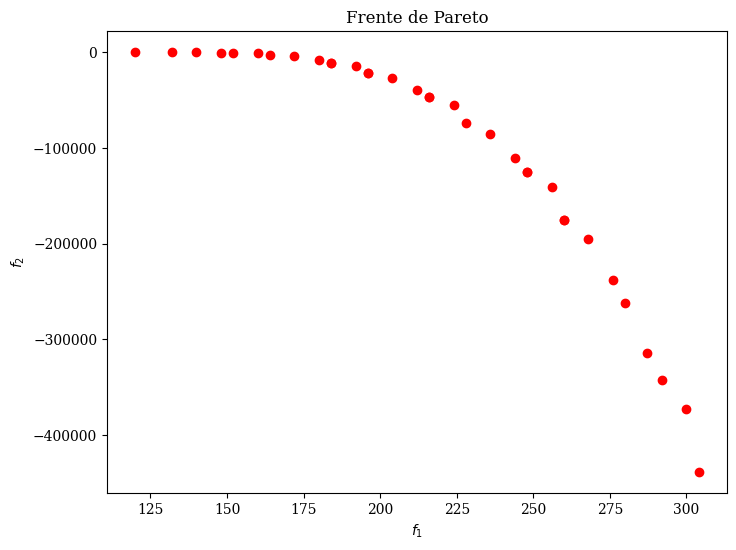

In [1345]:

from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.asf import ASF

weights = np.array([0.5, 0.5])#Peso que determina la importacia de las soluciones
decomp = ASF()
i = decomp.do(nF, 1/weights).argmin()

print("Best regarding ASF: Point \ni = %s\nF = %s\nX = %s" % (i, F[i], X[i]))


def ParetoFrontGraph(pf, title, color, nF, i, x):
    if x is True:
        plt.scatter(nF[:, 0], nF[:, 1], s=30, facecolors='none', edgecolors=color)
        plt.scatter(nF[i, 0], nF[i, 1], marker="x", color='red', s=200)
        plt.title(title)
        plt.show()
    else:
        plot = Scatter(title=title)
        plot.add(res.F, color=color)
        return plot
    
ParetoFrontGraph(F, "Frente de Pareto Normalizado", "blue", nF, i, True)
ParetoFrontGraph(F, "Frente de Pareto", "red", nF, i, False).show()

# Referencias

#### https://pymoo.org/getting_started/index.html
#### https://pymoo.org/customization/discrete.html
#### https://pymoo.org/interface/problem.html
